# CASE STUDY - Experimentation Platform (EP)  13.02.2025

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ptick
from matplotlib.ticker import ScalarFormatter
from scipy.stats import chisquare
import scipy.stats as stats

# Step1: Analyze the given results of the measurements

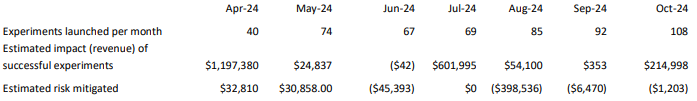

# 1.1 Replicate the table as DataFrame

In [2]:
result = {'month': ['Apr-24', 'May-24', 'Jun-24', 'Jul-24', 'Aug-24', 'Sep-24', 'Oct-24'],
        'experiments_launched': [40, 74, 67, 69, 85, 92, 108],
        'revenue_impact': [1197380, 24837, -42, 601995, 54100, 353, 214998],
        'risk_mitigated': [32810, 30858, -45393, 0, -398536, -6470, -1203]}
df_result = pd.DataFrame(result)
df_result

,month,experiments_launched,revenue_impact,risk_mitigated
0,Apr-24,40,1197380,32810
1,May-24,74,24837,30858
2,Jun-24,67,-42,-45393
3,Jul-24,69,601995,0
4,Aug-24,85,54100,-398536
5,Sep-24,92,353,-6470
6,Oct-24,108,214998,-1203


# 1.2 Plot the results to check visually

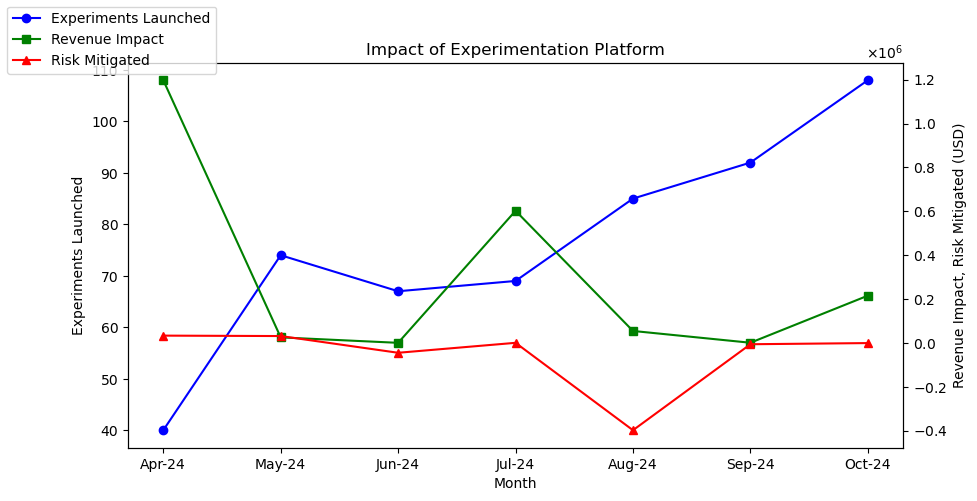

In [3]:
# Show in 1 plot
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(df_result['month'], df_result['experiments_launched'], marker='o', color='blue', label="Experiments Launched")
ax1.set_ylabel("Experiments Launched")
ax1.set_xlabel("Month")

ax2 = ax1.twinx()
ax2.plot(df_result['month'], df_result['revenue_impact'], marker='s', color='green', label="Revenue Impact")
ax2.plot(df_result['month'], df_result['risk_mitigated'], marker='^', color='red', label="Risk Mitigated")
ax2.set_ylabel("Revenue Impact, Risk Mitigated (USD)")
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style="sci", axis="y", scilimits=(6,6))

plt.title("Impact of Experimentation Platform")
fig.legend(loc="upper left")

plt.show()


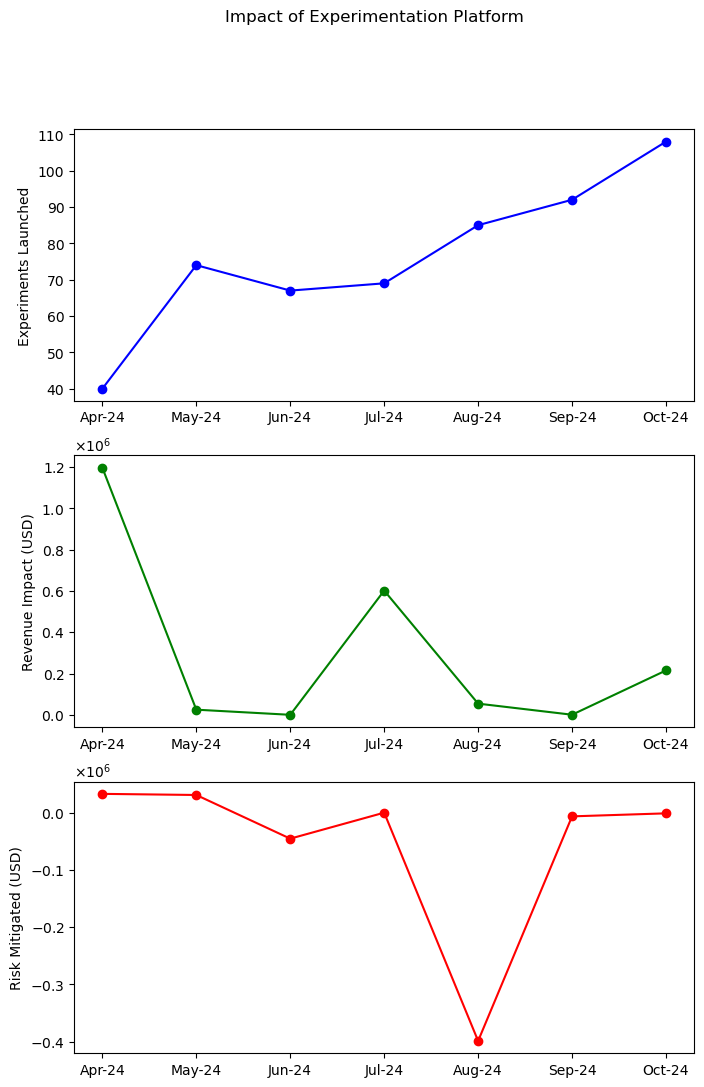

In [4]:
# Show in separate plots
fig = plt.figure(figsize=(8,12))
fig.suptitle('Impact of Experimentation Platform')

ax1 = fig.add_subplot(3,1,1)
ax1.plot(df_result['month'], df_result['experiments_launched'], marker='o', color='blue')
ax1.set_ylabel("Experiments Launched")

ax2 = fig.add_subplot(3,1,2)
ax2.plot(df_result['month'], df_result['revenue_impact'], marker='o', color='green')
ax2.set_ylabel("Revenue Impact (USD)")
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style="sci", axis="y", scilimits=(6,6))

ax2 = fig.add_subplot(3,1,3)
ax2.plot(df_result['month'], df_result['risk_mitigated'], marker='o', color='red')
ax2.set_ylabel("Risk Mitigated (USD)")
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style="sci", axis="y", scilimits=(6,6))

plt.show()

# 1.3 Analyze the plots and see if there are anything suspicious #


In the plots above, the following suspicious points are observed, and possible causes can be considered based on the formula to calculate the measurements.

1. While the number of experiments launched per month is constantly increasing, revenue impact and risk mitigated are not growing. More experiments should lead to higher cumulative results in general, but that is not the case here.
- The number of experiments is still too small, and in order to show improvement in the measurements, we need much larger sample size.
- The impact is diminishing as the users adapt to the changes. Earlier experiences often show higher impact because users are not used to the changes.
   
2. Estimated revenue impact has high variability and is very unstable. Suspicious spikes are found.
- Seasonality or other external factors might be creating the spikes. We need to observe the measurement in a longer term to find the effect of seasonality.
- There might be outlier experiments in the months with spikes, e.g April 24. Some experiments have extremely high impact and creating the spikes.

3. Risk mitigated is mostly negative value, and there is also a big drop in August.
- The formula for calculation of risk mitigated migh have error.
- 'Value' in the data is not propery calculated.

# Step2: Replicate the current method to calculate the measurement

# 2.1 Load sample data

In [5]:
# Read csv files (experiment_users.csv is missing, but not necessary)
df_ex = pd.read_csv('experiment_data/experiment.csv' ).reset_index(drop=True)
df_et = pd.read_csv('experiment_data/experiment_tracking.csv' ).reset_index(drop=True)

# Convert the data type
df_ex['start_date'] = pd.to_datetime(df_ex['start_date'])
df_ex['end_date'] = pd.to_datetime(df_ex['end_date'])
df_et['timestamp'] = pd.to_datetime(df_et['timestamp'])

df_experiment_data = df_ex.merge(df_et, how='inner', on=['exp_id'])

In [6]:
df_experiment_data.head()

,start_date,end_date,fraction,exp_id,exp_variant_id,user_id,event_type,value,timestamp
0,2023-02-18,2023-05-21,40,exp-0,b,0dab7ce7-f8bb-42fb-aaeb-4d7a50db0aaa,purchase,53.253934,2023-04-07 19:58:02
1,2023-02-18,2023-05-21,40,exp-0,b,756543a9-1d27-4eb2-b581-a118e232c802,purchase,48.720288,2023-05-06 09:31:31
2,2023-02-18,2023-05-21,40,exp-0,b,756543a9-1d27-4eb2-b581-a118e232c802,unsubscribe,1.000000,2023-04-12 05:52:44
3,2023-02-18,2023-05-21,40,exp-0,a,6af8e15b-7726-434b-831e-77839ad1142a,purchase,45.976249,2023-05-07 00:39:27
4,2023-02-18,2023-05-21,40,exp-0,b,6597d361-6146-42b4-9861-33df4467ffe9,purchase,26.755964,2023-02-19 06:08:04


# 2.2 Implement the formulas

In [7]:
# Replication of current method

def calculate_experiment_impact(daily_impact_per_unit: float, total_exposed_units: int, duration_of_impact: int,
                                audience_fraction: float, discount_factor: float) -> float:
    gross_projected_impact = (daily_impact_per_unit * total_exposed_units * duration_of_impact) / audience_fraction
    future_estimated_impact = gross_projected_impact * discount_factor
    
    return future_estimated_impact


def get_discount_factor(primary_metric_power: float, sample_ratio_mismatch: bool) -> float:
    return 0 if sample_ratio_mismatch else (2 * primary_metric_power) / (1 + primary_metric_power)


def sample_ratio_mismatch(control_count: int, treatment_count: int) -> bool:
    observed = [control_count, treatment_count]
    total = sum(observed)
    expected = [total/2, total/2]
    pvalue = chisquare(f_obs=observed, f_exp=expected)[1]
    alpha = 0.05
    
    return True if pvalue < alpha else False


def is_significant(control_values, treatment_values, alpha=0.05):
    _, p_value = stats.ttest_ind(control_values, treatment_values, equal_var=False)
    return p_value < alpha

def calculate_results(experiment_data: pd.DataFrame) -> list:
    impact_results = []
    risk_results = []
    grouped = experiment_data.groupby('exp_id')
    unique_users_total = experiment_data['user_id'].nunique()
    
    for exp_id, data in grouped:
        # Suppose 'a' is control variant and others are treatment variants
        control_group = data[data['exp_variant_id'] == 'a']['value']
        treatment_group = data[data['exp_variant_id'] != 'a']['value']
        
        # Check if Sample Ratio Mismatch occured
        srm = sample_ratio_mismatch(len(control_group), len(treatment_group))
        
        total_sum = data['value'].sum()
        unique_users = data['user_id'].nunique()
        duration_of_impact = (data['end_date'].max() - data['start_date'].min()).days + 1
        daily_impact = total_sum / (unique_users * duration_of_impact)
        audience_fraction = data['fraction'].mean()
        primary_metric_power = min(1, unique_users/unique_users_total)
        discount_factor = get_discount_factor(primary_metric_power, srm)
        
        if is_significant(control_group, treatment_group):
            if len(control_group) < len(treatment_group):  # Winning treatment variant
                impact = calculate_experiment_impact(daily_impact, unique_users, duration_of_impact, audience_fraction, discount_factor)
                impact_results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'estimated_impact': impact})
            else:     # Winning control variant
                risk_mitigated = calculate_experiment_impact(daily_impact, unique_users, duration_of_impact, audience_fraction, discount_factor)
                risk_results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'risk_mitigated':risk_mitigated})
    
    return [pd.DataFrame(impact_results), pd.DataFrame(risk_results)]

df_impact = calculate_results(df_experiment_data)[0]
df_risk_mitigated = calculate_results(df_experiment_data)[1]


# 2.3 Show results on the sample data

Possible erros:
- Calculation of primary_metric_power is wrong
- Calculation of sample_ratio_mismatch is wrong. I got too many sample ratio mismatch, which makes the results 0.

In [8]:
df_impact

,exp_id,start_date,estimated_impact
0,exp-15,2023-02-24,0.000000
1,exp-19,2023-02-28,400.097911
2,exp-7,2023-04-27,3160.542186


In [9]:
df_risk_mitigated

,exp_id,start_date,risk_mitigated
0,exp-16,2023-01-19,400.430127
1,exp-18,2023-01-03,0.000000
2,exp-2,2023-01-23,0.000000
3,exp-20,2023-05-01,0.000000
4,exp-26,2023-01-25,0.000000
5,exp-27,2023-03-28,0.000000
6,exp-5,2023-03-24,0.000000


# Step3: Present solutions for improvement and new metrics

# 3.1 Data preprocessing

Assign -10 for 'value' if event_type is unsubscribe. Unsubscribe should have negative impact while purchase has positive impact.

In [10]:
df_experiment_data.loc[df_et['event_type'] == 'unsubscribe', 'value'] = -10

To remove outliers, clip values between 20% and 80% percentile.

In [11]:
percentile_20 = df_experiment_data['value'].quantile(0.2)
percentile_80 = df_experiment_data['value'].quantile(0.8)
df_experiment_data['value'] = df_experiment_data['value'].clip(lower=percentile_20, upper=percentile_80)

# 3.2 Improvement to the current method

- Use stability adjustment to filter outliers.
- Calculate risk reduction rate instead of measuring the total risk mitigated. This might help camparing the results more properly.
- 

In [12]:
# Improved method v1

def calculate_experiment_impact(daily_impact_per_unit: float, total_exposed_units: int, duration_of_impact: int,
                                audience_fraction: float, discount_factor: float, stability_factor: float) -> float:
    gross_projected_impact = (daily_impact_per_unit * total_exposed_units * duration_of_impact) / audience_fraction
    future_estimated_impact = gross_projected_impact * discount_factor * stability_factor
    
    return future_estimated_impact


def get_discount_factor(primary_metric_power: float, sample_ratio_mismatch: bool) -> float:
    return 0 if sample_ratio_mismatch else (2 * primary_metric_power) / (1 + primary_metric_power)


def sample_ratio_mismatch(control_count: int, treatment_count: int) -> bool:
    observed = [control_count, treatment_count]
    total = sum(observed)
    expected = [total/2, total/2]
    pvalue = chisquare(f_obs=observed, f_exp=expected)[1]
    alpha = 0.1**100 # Set a very small number to avoid elimating too many exp
    # if pvalue < alpha:
    #   print('Sample Ratio Mismatch occured!')
    return True if pvalue < alpha else False


def is_significant(control_values, treatment_values, alpha=0.05):
    _, p_value = stats.ttest_ind(control_values, treatment_values, equal_var=False)
    return p_value < alpha


def stability_adjustment(experiment_data):
    """
    Compute a stability adjustment factor to penalize experiments with high variance.
    """
    value_std = experiment_data['value'].std()
    value_mean = experiment_data['value'].mean()

    return max(0, 1 - (value_std / (value_mean + 1)))


def calculate_results(experiment_data: pd.DataFrame) -> list:
    impact_results = []
    risk_results = []
    grouped = experiment_data.groupby('exp_id')
    unique_users_total = experiment_data['user_id'].nunique()
    
    for exp_id, data in grouped:
        # Suppose 'a' is control variant and others are treatment variants
        control_group = data[data['exp_variant_id'] == 'a']['value']
        treatment_group = data[data['exp_variant_id'] != 'a']['value']
        
        # Check if Sample Ratio Mismatch occured
        srm = sample_ratio_mismatch(len(control_group), len(treatment_group))
        
        total_sum = data['value'].sum()
        unique_users = data['user_id'].nunique()
        duration_of_impact = (data['end_date'].max() - data['start_date'].min()).days + 1
        daily_impact = total_sum / (unique_users * duration_of_impact)
        audience_fraction = data['fraction'].mean()
        primary_metric_power = min(1, unique_users/unique_users_total)
        discount_factor = get_discount_factor(primary_metric_power, srm)
        stability_factor = stability_adjustment(data)
        
        if is_significant(control_group, treatment_group):
            if len(control_group) < len(treatment_group):  # Winning treatment variant
                impact = calculate_experiment_impact(daily_impact, unique_users, duration_of_impact, 
                                                     audience_fraction, discount_factor, stability_factor)
                impact_results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'estimated_impact': impact})
            else:     # Winning control variant
                risk_mitigated = calculate_experiment_impact(daily_impact, unique_users, duration_of_impact, 
                                                             audience_fraction, discount_factor, stability_factor)
                risk_results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'risk_mitigated':risk_mitigated})
    
    return [pd.DataFrame(impact_results), pd.DataFrame(risk_results)]

df_impact = calculate_results(df_experiment_data)[0]
df_risk_mitigated = calculate_results(df_experiment_data)[1]


def calculate_risk_reduction_rate(df_risk_mitigated, experiment_data):
    """
    Risk Reduction Rate
    """
    df_risk_mitigated = df_risk_mitigated.copy()
    baseline_losses = experiment_data.groupby('exp_id')['value'].sum().reset_index()
    baseline_losses.rename(columns={'value': 'baseline_loss'}, inplace=True)

    df_risk_mitigated = df_risk_mitigated.merge(baseline_losses, on='exp_id', how='left')
    df_risk_mitigated['risk_reduction_rate'] = df_risk_mitigated['risk_mitigated'] / df_risk_mitigated['baseline_loss']

    return df_risk_mitigated[['exp_id', 'start_date', 'risk_mitigated', 'risk_reduction_rate']]

df_risk_mitigated = calculate_risk_reduction_rate(df_risk_mitigated, df_experiment_data)


In [13]:
df_impact

,exp_id,start_date,estimated_impact
0,exp-15,2023-02-24,209.020468
1,exp-19,2023-02-28,289.602883
2,exp-7,2023-04-27,1670.695319


In [14]:
df_risk_mitigated

,exp_id,start_date,risk_mitigated,risk_reduction_rate
0,exp-16,2023-01-19,249.003801,0.000495
1,exp-18,2023-01-03,211.070186,0.000520
2,exp-2,2023-01-23,371.386297,0.000667
3,exp-20,2023-05-01,351.389867,0.000996
4,exp-26,2023-01-25,425.592016,0.000772
5,exp-27,2023-03-28,602.402481,0.001688
6,exp-5,2023-03-24,350.723456,0.000579


In [15]:
# Plot
# Extract year and month
df_impact['year_month'] = df_impact['start_date'].dt.to_period('M').astype(str)
df_risk_mitigated['year_month'] = df_risk_mitigated['start_date'].dt.to_period('M').astype(str)

# Group data by month
df_monthly_impact = df_impact.groupby('year_month').agg(
    experiment_count=('exp_id', 'count'),
    total_estimated_impact=('estimated_impact', 'sum')
).reset_index()

df_monthly_risk_mitigated = df_risk_mitigated.groupby('year_month').agg(
    experiment_count=('exp_id', 'count'),
    total_risk_mitigated =('risk_mitigated', 'sum')
).reset_index()

df_monthly_risk_reduction = df_risk_mitigated.groupby('year_month').agg(
    experiment_count=('exp_id', 'count'),
    total_risk_reduction =('risk_reduction_rate', 'mean')
).reset_index()

# Sum experiment counts
df_monthly_merged = pd.merge(df_monthly_impact, df_monthly_risk_mitigated, on='year_month',
                             how='outer', suffixes=('_impact', '_risk')).fillna(0)
df_monthly_merged['total_experiment_count'] = df_monthly_merged['experiment_count_impact'] + df_monthly_merged['experiment_count_risk']

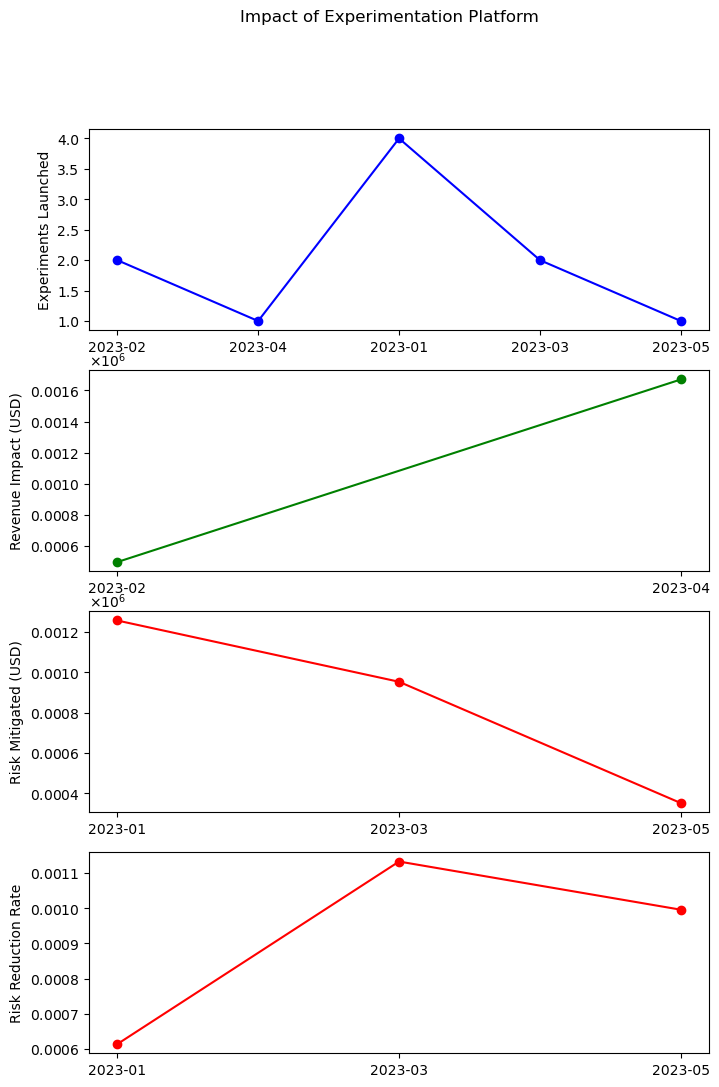

In [16]:
# Plot
fig = plt.figure(figsize=(8,12))
fig.suptitle('Impact of Experimentation Platform')

ax1 = fig.add_subplot(4,1,1)
ax1.plot(df_monthly_merged['year_month'], df_monthly_merged['total_experiment_count'], marker='o', color='blue')
ax1.set_ylabel("Experiments Launched")

ax2 = fig.add_subplot(4,1,2)
ax2.plot(df_monthly_impact['year_month'], df_monthly_impact['total_estimated_impact'], marker='o', color='green')
ax2.set_ylabel("Revenue Impact (USD)")
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style="sci", axis="y", scilimits=(6,6))

ax2 = fig.add_subplot(4,1,3)
ax2.plot(df_monthly_risk_mitigated['year_month'], df_monthly_risk_mitigated['total_risk_mitigated'], marker='o', color='red')
ax2.set_ylabel("Risk Mitigated (USD)")
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style="sci", axis="y", scilimits=(6,6))

ax2 = fig.add_subplot(4,1,4)
ax2.plot(df_monthly_risk_reduction['year_month'], df_monthly_risk_reduction['total_risk_reduction'], marker='o', color='red')
ax2.set_ylabel("Risk Reduction Rate")
ax2.yaxis.set_major_formatter(ptick.ScalarFormatter(useMathText=True))
ax2.ticklabel_format(style="sci", axis="y")

plt.show()

# 3.3 Present new metrics

- New metric 1 - Positive rate

Calculate the ratio of experiments where treatment variants have higher impact than control variants.

Advantages: Robust to outliers

Disadvantages: Does not measure the cumulative impact.  

In [17]:
def calculate_positive_rate(experiment_data):
    """
    Calculate the ratio of experiments where treatment variants have higher impact than control variants.
    """
    results = []
    total_experiments = experiment_data['exp_id'].nunique()

    grouped = experiment_data.groupby('exp_id')
    for exp_id, data in grouped:
        control_group = data[data['exp_variant_id'] == 'a']['value']
        treatment_group = data[data['exp_variant_id'] != 'a']['value']

        if len(control_group) > 0 and len(treatment_group) > 0 and is_significant(control_group, treatment_group):
            if treatment_group.mean() > control_group.mean():
                results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'positive_impact':1})
            else:
                results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'positive_impact':0})

    return pd.DataFrame(results)

df_results = calculate_positive_rate(df_experiment_data)

# Extract year and month
df_results['year_month'] = df_results['start_date'].dt.to_period('M').astype(str)

# Group data by month
df_monthly = df_results.groupby('year_month').agg(
    experiment_count=('exp_id', 'count'),
    positive_rate =('positive_impact', 'mean')
).reset_index()

df_monthly

,year_month,experiment_count,positive_rate
0,2023-01,4,1.0
1,2023-02,2,1.0
2,2023-03,2,1.0
3,2023-04,1,1.0
4,2023-05,1,1.0


- New metric 2 - Positive impact

Calculate the difference between mean value of treatment group and control group.

Advantages: It simply focuses on the value, so easy to understand the implication of result.

Disadvantages: Sensitive to outliers.

In [18]:
def calculate_positive_impact(experiment_data):
    """
    Calculate the difference between mean value in treatment group and control group.
    """
    results = []
    total_experiments = experiment_data['exp_id'].nunique()

    grouped = experiment_data.groupby('exp_id')
    for exp_id, data in grouped:
        control_group = data[data['exp_variant_id'] == 'a']['value']
        treatment_group = data[data['exp_variant_id'] != 'a']['value']

        if len(control_group) > 0 and len(treatment_group) > 0 and is_significant(control_group, treatment_group):
          results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'positive_impact':treatment_group.mean() - control_group.mean()})

    return pd.DataFrame(results)

df_results = calculate_positive_impact(df_experiment_data)

# Extract year and month
df_results['year_month'] = df_results['start_date'].dt.to_period('M').astype(str)

# Group data by month
df_monthly = df_results.groupby('year_month').agg(
    experiment_count=('exp_id', 'count'),
    positive_impact =('positive_impact', 'mean')
).reset_index()

df_monthly


,year_month,experiment_count,positive_impact
0,2023-01,4,10.592608
1,2023-02,2,10.610860
2,2023-03,2,8.752688
3,2023-04,1,13.965866
4,2023-05,1,5.581859


- New metric 3 - Positive impact v2

Calculate the difference between mean value of treatment group and control group, and divide by the mean value of control group.

Advantages: Less sensitive to outliers.

Disadvantages: This might not correctly measure the impact.

In [19]:
def calculate_positive_impact_v2(experiment_data):
    """
    Calculate the difference between mean value of treatment group and control group, and divide by the mean value of control group.
    """
    results = []
    total_experiments = experiment_data['exp_id'].nunique()

    grouped = experiment_data.groupby('exp_id')
    for exp_id, data in grouped:
        control_group = data[data['exp_variant_id'] == 'a']['value']
        treatment_group = data[data['exp_variant_id'] != 'a']['value']

        if len(control_group) > 0 and len(treatment_group) > 0 and is_significant(control_group, treatment_group):
          results.append({'exp_id': exp_id, 'start_date': data['start_date'].min(), 'positive_impact':(treatment_group.mean() - control_group.mean()) / control_group.mean()})

    return pd.DataFrame(results)

df_results = calculate_positive_impact_v2(df_experiment_data)

# Extract year and month
df_results['year_month'] = df_results['start_date'].dt.to_period('M').astype(str)

# Group data by month
df_monthly = df_results.groupby('year_month').agg(
    experiment_count=('exp_id', 'count'),
    positive_impact =('positive_impact', 'mean')
).reset_index()

df_monthly


,year_month,experiment_count,positive_impact
0,2023-01,4,0.359805
1,2023-02,2,0.506895
2,2023-03,2,0.252043
3,2023-04,1,0.463916
4,2023-05,1,0.150314


- New metric 4 - Positive score

Combine positive rate and positive impact. Positive score is calculated by multiplying these values.

Advantages: Effectively measure the impact.

Disadvantages: Not easy to understand the the implication of result.

In [20]:
def calculate_positive_score(experiment_data):
    """
    Combine positive rate and positive impact. Positive score is calculated by multiplying these values.
    """
    df_positive_rate = calculate_positive_rate(experiment_data)
    df_positive_rate['year_month'] = df_positive_rate['start_date'].dt.to_period('M').astype(str)
    df_monthly_positive_rate = df_positive_rate.groupby('year_month').agg(
        experiment_count=('exp_id', 'count'),
        positive_rate =('positive_impact', 'mean')
    ).reset_index()

    df_positive_impact = calculate_positive_impact(experiment_data)
    df_positive_impact['year_month'] = df_positive_impact['start_date'].dt.to_period('M').astype(str)
    df_monthly_positive_impact = df_positive_impact.groupby('year_month').agg(
        experiment_count=('exp_id', 'count'),
        positive_impact =('positive_impact', 'mean')
    ).reset_index()

    df_merged = pd.merge(df_monthly_positive_rate, df_monthly_positive_impact, on='year_month', how='inner')
    df_merged['positive_score'] = df_merged['positive_impact'] * df_merged['positive_rate']

    return df_merged

df_monthly = calculate_positive_score(df_experiment_data)

df_monthly

,year_month,experiment_count_x,positive_rate,experiment_count_y,positive_impact,positive_score
0,2023-01,4,1.0,4,10.592608,10.592608
1,2023-02,2,1.0,2,10.610860,10.610860
2,2023-03,2,1.0,2,8.752688,8.752688
3,2023-04,1,1.0,1,13.965866,13.965866
4,2023-05,1,1.0,1,5.581859,5.581859
